In [1]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import models
from keras import layers
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

def show_image(url, size = (8,8)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize = size)
    plt.axis('off')
    _ = plt.imshow(img, interpolation='lanczos')

Using TensorFlow backend.


# 1. Last time - fully connected network

In [2]:


# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Flatten images and scale pixels into [0,1]
train_images_flat = train_images.reshape((60000, 28 * 28))
train_images_flat = train_images_flat.astype('float32') / 255

test_images_flat = test_images.reshape((10000, 28 * 28))
test_images_flat = test_images_flat.astype('float32') / 255

# One-hot encoding for labels
train_labels_oneHot = to_categorical(train_labels)
test_labels_oneHot = to_categorical(test_labels)


# Define the model
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

network.summary()

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Fit the model
history = network.fit(
    train_images_flat,
    train_labels_oneHot,
    epochs=10,
    batch_size=512,
    validation_data=(test_images_flat, test_labels_oneHot)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.4030 - acc: 0.8851 - val_loss: 0.2470 - val_acc: 0.9235
Epoch 2/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.1760 - acc: 0.9494 - val_loss: 0.1792 - val_acc: 0.9448
Epoch 3/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.1194 - acc: 0.9656 - val_loss: 0.1365 - val_acc: 0.9588
Epoch 4/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.0900 - acc: 0.9742 - val_loss: 0.1005 - val_acc: 0.9711
Epoch 5/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.0690 - acc: 0.9797 - val_loss: 0.0912 - val_acc: 0.9717
Epoch 6/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.0549 - acc: 0.9845 - val_loss: 0.0968 - val_acc: 0.9674
Epoch 7/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.0443 - acc: 0.9871 - val_loss: 0.0722 - val_acc: 0.97

# 2. Convolutional Neural Networks (CNNs, ConvNets)

### Architecture ###

1. In CNN we exploit the fact that inputs are <b>images</b> to <br>
<b>reduce the amount of parameters</b> in the network.<br>
Note that if we use Dense layers for images they need to <br> be flatten
and it is more difficult to extract spatial patterns. <br><br>

2. Typical layers in CNN are <b>Conv2D, Pooling</b> and <b>Dense</b> (only as the last layer).<br>
Sometimes we use some layers connected to relgularization e.g. <b>Droprout</b>.


3. <!--In dense architecture the spatial distance between pixels is not taken into account (at least initially).<br>-->
The idea of CNN is searching for local patterns rather then global (as in dense layers).<br> Often it is justified: e.g. noses of cats and dogs are diffrent. <br>
Thus, in CNN neurons are connected only to a small region of the previous layer.




### Convolution layer ###


1. A single convolution layer have many convolutions (filters) <br>
that are used to scan input in search of some local patterns<br> 
e.g. the vertical/horizontal edges, shapes, textures etc. <br>
Filters are tensors with weights to learn. 



2. In order to have multiple patterns examined we have multiple filters in each layer. <br> 
Neurons in a layer are arranged in 3 dimensions (not including the batch dimension): <br>
width, height and depth (<a href='http://ki.pwr.edu.pl/lemiesz/info/conv-example.xlsx'>example from fastai in Excel<a>):  <br>

$\;\;\;\;$ (28,28,1)  input  $\;\;\;\; \rightarrow \;\;\;\;$    32  filters 3x3   $\;\;\;\; \rightarrow \;\;\;\;$    (26,26,32) output 



3. The local patterns that are learned are translation invariant. <br>
After learning some pattern in the lower-right corner of a picture, <br>
a convnet can recognize it anywhere. <br><br>
A densely connected network would have to learn the pattern anew if it <br>
appeared at a new location. This makes convnets data efficient for images:<br>
they need fewer training samples to learn representations that have generalization power.


4.  As we have sequance of conv layers, we can learn spatial hierarchies of patterns.<br>
A first conv layer will learn small local patterns such as edges, a second convolution <br>
layer will learn larger patterns made of the features of the first layers, and so on. <br> 
This allows convnets to efficiently learn increasingly complex and abstract visual concepts.



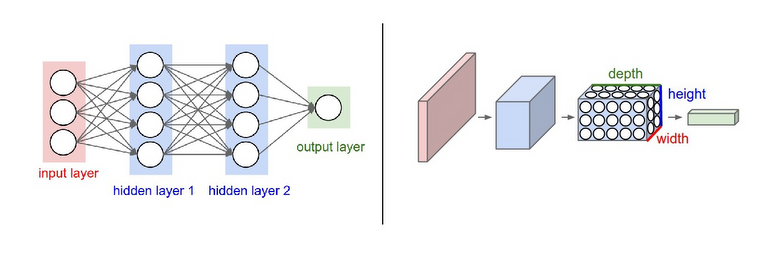

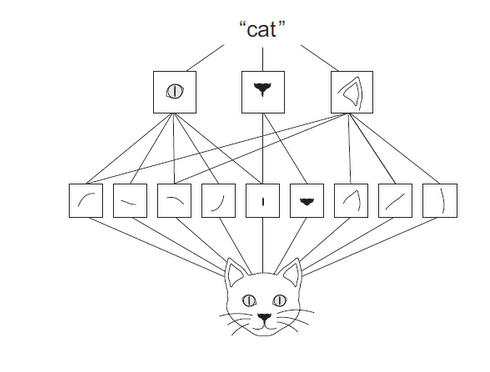

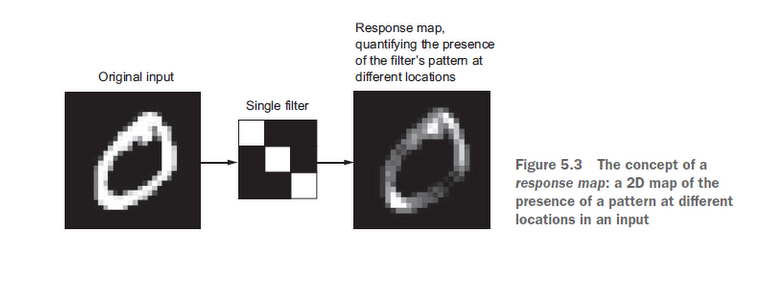

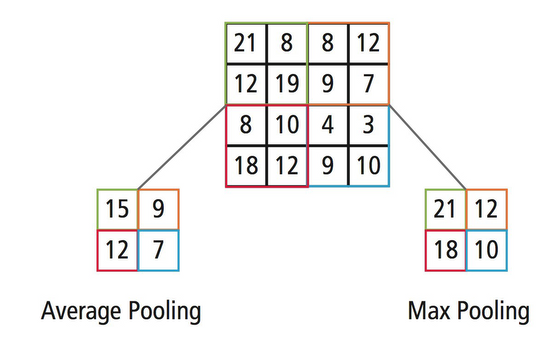

In [43]:
# Most images from Deep Learning with Python book by F. Chollet
show_image('http://ki.pwr.edu.pl/lemiesz/info/neural_net2.jpeg', size = (13,13))
show_image('http://ki.pwr.edu.pl/lemiesz/info/cat.png', size = (8,8))
show_image('http://ki.pwr.edu.pl/lemiesz/info/response_map.png', size = (13,13))
show_image('http://ki.pwr.edu.pl/lemiesz/info/polling.jpeg', size = (9,9))

### MaxPooling layer


1. Pooling layer (or subsampling layer) is typically used <br>
after each conv layers to downspample feature maps <br>
$ $<br>
Why max pooling tends to work better then average pooling? <br> 
Feature maps encode the spatial presence of some pattern  and it's<br>
usually more informative to look at the maximal presence than at<br>
their average presence.


2. Max pooling consists of extracting windows from the input feature maps<br>
and outputting the max value. It’s conceptually similar to convolution,  <br>
except that instead of transforming windows via a linear transformation <br>
we use max operation. <br>


    MaxPooling2D((2, 2))  downsamples the feature maps by a factor of 2



3. Why downsample feature maps this way? <br>
See example below "No max-pooling". In the example:

    - the final feature map has 24 × 24 × 64 = 30,976 elements <br>
       that need to be connected with a dense layer. <br>
       MaxPooling decreses the number of parameters to train.<br>
        $ $      
              
    -  without downsampling high-level patterns learned by the convnet <br>
       are still very small with regard to the initial input <br>
       (try recognizing a digit by looking through 5 × 5 pixels windows).<br>
       We need the feature maps from the last convolution layer to contain <br>
       information about the larger parts of the input image.



Sometimes instead MaxPooling convolution with <b>stride $s>1$</b>   is used (we skip some windows). 


### Dropout layer - regularization technique 

For each hidden layer, for each training sample, for each iteration:<br>
ignore (zero out) a random fraction <b>p</b> of neurons (and corresponding activations).


We use Dropout to prevent over-fitting: <br>
neurons may develop co-dependency amongst each other during training, which <br> 
limits their individual power leading to over-fitting of training data.

# 3. Toy example - MNIST with Convnet


Convolution layer is defined by two key parameters:
1. Size of the filters - these are typically 3 × 3 or 5 × 5. 
2. Depth of the output feature map — the number of filters.

In Keras Conv2D layers, these parameters are the first arguments passed to the layer:<br>

          Conv2D( output_depth, (window_height, window_width) )
          
Sometimes 1 x 1 filters are used in a layer to reduce the number of filters (dimension reduction or projection).         

In [6]:
# # Define a very basic Convnet
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                92170     
Total params: 110,986
Trainable params: 110,986
Non-trainable params: 0
_________________________________________________________________


In [7]:
# No max-pooling

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                368650    
Total params: 387,466
Trainable params: 387,466
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Typical architecture with MaxPool after each Conv2D

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                36928     
__________

In [16]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images.shape

(60000, 28, 28)

In [17]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=512,
    validation_data=(test_images, test_labels)
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.5373 - acc: 0.8334 - val_loss: 0.1991 - val_acc: 0.9380
Epoch 2/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.1196 - acc: 0.9642 - val_loss: 0.0659 - val_acc: 0.9782
Epoch 3/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.0707 - acc: 0.9779 - val_loss: 0.1019 - val_acc: 0.9680
Epoch 4/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.0498 - acc: 0.9851 - val_loss: 0.1337 - val_acc: 0.9553
Epoch 5/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.0400 - acc: 0.9872 - val_loss: 0.0338 - val_acc: 0.9884
Epoch 6/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.0320 - acc: 0.9897 - val_loss: 0.0465 - val_acc: 0.9851
Epoch 7/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.0262 - acc: 0.9919 - val_loss: 0.0414 - val_acc

Densely-connected network: worse validation accuracy, more parameteres <br>
Convolution netetork: better validation accuracy, less parameters